# CC Fraud Analysis

_created by Austin Poor_

Analysis of credit card fraud data. Data source: https://www.kaggle.com/mlg-ulb/creditcardfraud

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
df = pd.read_csv("data/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## EDA

Look at info about size of dataset and class balances

In [3]:
print(f"n observations => {df.shape[0]:,d}")
print(f"n features     => {df.shape[1]-1:7d}")

print(f"class balance  => {df.Class.mean():7.5f}")

n observations => 284,807
n features     =>      30
class balance  => 0.00173


It looks like the classes are _super_ inbalanced

Plotting distributions for features

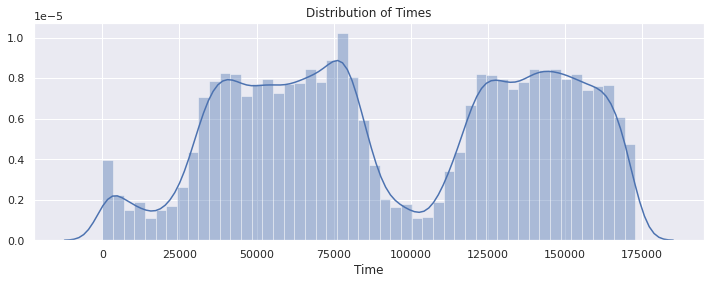

In [4]:
plt.figure(figsize=(12,4))
sns.distplot(df.Time)
plt.title("Distribution of Times");

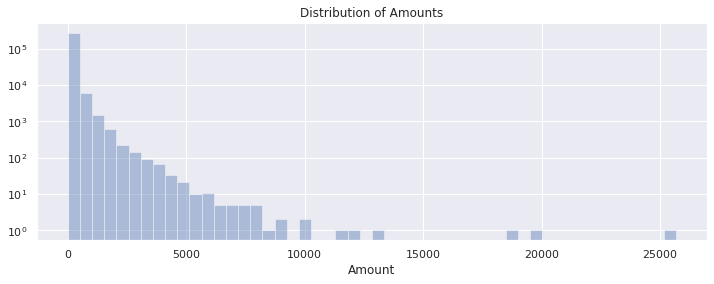

In [5]:
plt.figure(figsize=(12,4))
sns.distplot(df.Amount,kde=False)
plt.yscale('log')
plt.title("Distribution of Amounts");

Distributions for PCA transformed columns `V1`-`V28`

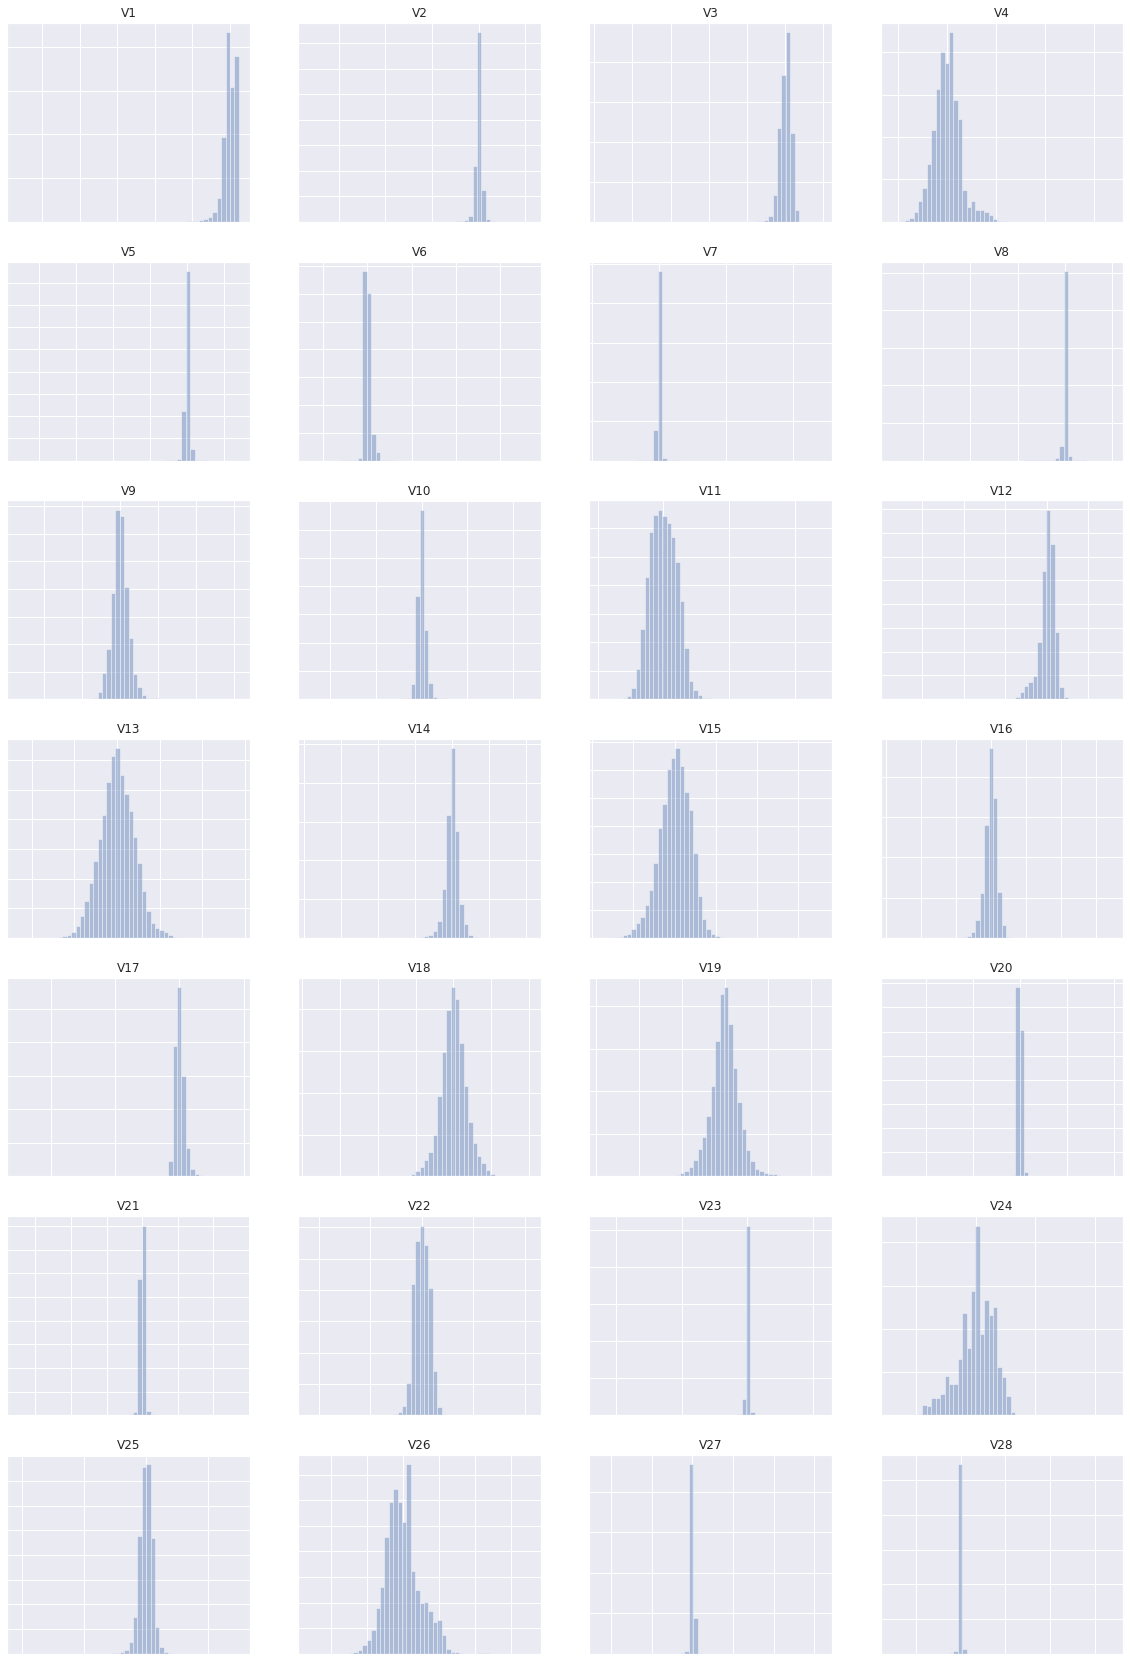

In [6]:
plt.figure(figsize=(20,30))
for i in range(1,29):
    plt.subplot(7,4,i)
    sns.distplot(df[f"V{i}"],kde=False)
    plt.title(f"V{i}")
    plt.xlabel("")
    frame1 = plt.gca()
    frame1.axes.xaxis.set_ticklabels([])
    frame1.axes.yaxis.set_ticklabels([])

Examine the correlation between each feature and the target

In [7]:
df.corr()["Class"]\
    .reset_index()\
    .rename(columns={
        "index":"ColName",
        "Class":"Correlation"
    })\
    .sort_values(
        "Correlation",
        ascending=False,
        key=lambda n: abs(n)
    ).query("ColName != 'Class'")

,ColName,Correlation
17,V17,-0.326481
14,V14,-0.302544
12,V12,-0.260593
10,V10,-0.216883
16,V16,-0.196539
3,V3,-0.192961
7,V7,-0.187257
11,V11,0.154876
4,V4,0.133447
18,V18,-0.111485


---

## Model Building

In [8]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [9]:
X = df.drop(columns="Class")
y = df.Class
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [10]:
scaler = StandardScaler()
Xs_train = scaler.fit_transform(X_train)

In [11]:
class_weight = y_train.mean()
class_weight

0.0017405349009851328

### Logistic Regression

In [12]:
logr = LogisticRegression(
    max_iter=10_000,
    class_weight={
        0: 1-class_weight,
        1: class_weight
    },
    n_jobs=-1
)
logr

LogisticRegression(class_weight={0: 0.9982594650990149,
                                 1: 0.0017405349009851328},
                   max_iter=10000, n_jobs=-1)

In [13]:
from sklearn.metrics import roc_auc_score, make_scorer, balanced_accuracy_score, accuracy_score

In [14]:
scores = cross_val_score(
    logr,
    Xs_train,
    y_train,
    scoring=make_scorer(accuracy_score),
    cv=10
)
print(f"LogisticRegression Accuracy: {np.mean(scores):.6f} ({np.std(scores):.6f})")

LogisticRegression Accuracy: 0.998495 (0.000157)


In [15]:
scores = cross_val_score(
    logr,
    Xs_train,
    y_train,
    scoring=make_scorer(balanced_accuracy_score),
    cv=10
)
acc_logr = np.mean(scores)
print(f"LogisticRegression Balanced Accuracy: {acc_logr:.6f} ({np.std(scores):.6f})")

LogisticRegression Balanced Accuracy: 0.567983 (0.042600)


### Random Forrest

In [ ]:
rfc = RandomForestClassifier(
    class_weight={
        0:1-class_weight,
        1:class_weight
    }
)
rfc.fit(X_train,y_train)

In [ ]:
scores = cross_val_score(
    rfc,
    X_train,
    y_train,
    scoring=make_scorer(balanced_accuracy_score),
    cv=10
)
acc_rfc = np.mean(scores)
print(f"RandomForrest Balanced Accuracy: {acc_rfc:.6f} ({np.std(scores):.6f})")

### XGBoost

In [ ]:
from xgboost import XGBClassifier

In [ ]:
X_val, X_test, y_val, y_test = train_test_split(X_test,y_test,test_size=0.33)

In [ ]:
xgbc = XGBClassifier()
xgbc.fit(
    X_train,
    y_train,
    eval_set=[
        (X_val,y_val)
    ],
    verbose=False
)

In [ ]:
scores = cross_val_score(
    xgbc,
    X_train,
    y_train,
    scoring=make_scorer(balanced_accuracy_score),
    cv=10
)
acc_xgbc = np.mean(scores)
print(f"XGBoost Balanced Accuracy: {acc_xgbc:.6f} ({np.std(scores):.6f})")

### LightGBM

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
lgbc = LGBMClassifier(
    class_weight={
        0: 1-class_balance,
        1: class_balance
    }
)
lgbc.fit(
    X_train,
    y_train,
    eval_set=[
        (X_val,y_val)
    ],
    verbose=False
)

In [ ]:
scores = cross_val_score(
    lgbc,
    X_train,
    y_train,
    scoring=make_scorer(balanced_accuracy_score),
    cv=10
)
acc_lgbc = np.mean(scores)
print(f"LightGBM Balanced Accuracy: {acc_lgbc:.6f} ({np.std(scores):.6f})")

In [ ]:
pd.Series(
    data=[acc_logr,acc_rfc,acc_xgbc,acc_lgbc],
    index=["Logistic","RandomForrest","XGBoost","LightGBM"],
    name="BalancedAccuracies"
)

## Grid Search

### Logistic Regression

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
Xs_train = scaler.transform(X_train)
Xs_test  = scaler.transform(X_test)

In [ ]:
grid_logr = GridSearchCV(
    logr,
    [{
        "C":np.linspace(0,1.0,5),
        "class_weight":[None,{0:1-class_weight,1:class_weight}],
        "n_jobs":[-1]
        "max_iter":10 ** np.arange(3,7)
    }],
    scoring=make_scorer(balanced_accuracy_score),
    cv=5
)
grid_logr.fit(X_train,y_train)
grid_logr.best_params

In [ ]:
# X_val, X_test, y_val, y_test = train_test_split(X_test,y_test,test_size=0.33)